In [1]:
#!pip install git+https://github.com/modAL-python/modAL.git

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from modAL.disagreement import max_std_sampling
from modAL.models import ActiveLearner, CommitteeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from modAL.uncertainty import uncertainty_sampling

In [3]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_pool, X_test, Y_pool, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [4]:
learners = []  
sub_size = len(X_train) // 4  # Size of each subset for training individual learners
queries = len(X_pool)  # Total number of queries to make

model = RandomForestRegressor(random_state=0)  

for i in range(4):
    start_index = i * sub_size  
    end_index = (i + 1) * sub_size 
    X_subset = X_train[start_index:end_index]  # Subset of training instances
    y_subset = y_train[start_index:end_index]  # Subset of corresponding labels
    learner = ActiveLearner(estimator=model, X_training=X_subset, y_training=y_subset)
    learners.append(learner)  

# Create a committee regressor with the learners
committee = CommitteeRegressor(
    learner_list=learners,  
    query_strategy=max_std_sampling  # Query strategy to select instances for labeling
)


# Active learning with uncertainty sampling

In [5]:
x_pool = X_pool
y_pool = Y_pool

scores_mss = []
for i in range(queries):
    index, _ = committee.query(x_pool) # returns the index of the instance in x_pool that the committee of active learners is most uncertain about
    index = index[0]
    x = x_pool[index]
    y = y_pool[index]
    x_pool = np.delete(x_pool, obj=index, axis=0)
    y_pool = np.delete(y_pool, obj=index, axis=0)
    committee.teach(X=[x], y=[y])
    y_pred = committee.predict(X_test)        
    r2 = r2_score(y_test, y_pred)
    if i%10 == 0:
        print(f"R2 score after query {str(i)}: {r2:0.3f}") 
    scores_mss.append(r2)

R2 score after query 0: 0.382
R2 score after query 10: 0.379
R2 score after query 20: 0.388
R2 score after query 30: 0.417
R2 score after query 40: 0.443
R2 score after query 50: 0.448
R2 score after query 60: 0.483
R2 score after query 70: 0.488
R2 score after query 80: 0.491


# Active learning with random sampling

In [6]:
x_pool = X_pool
y_pool = Y_pool

scores_rs = []
for i in range(queries):
    index = random.randint(0, len(x_pool) - 1) # random index within the range of the current x_pool
    x = x_pool[index]
    y = y_pool[index]
    x_pool = np.delete(x_pool, obj=index, axis=0)
    y_pool = np.delete(y_pool, obj=index, axis=0)
    committee.teach(X=[x], y=[y])
    y_pred = model.predict(X_test)        
    r2 = r2_score(y_test, y_pred)
    if i%10 == 0:
        print(f"R2 score after query {str(i)}: {r2:0.3f}")       
    scores_rs.append(r2)

R2 score after query 0: 0.482
R2 score after query 10: 0.503
R2 score after query 20: 0.504
R2 score after query 30: 0.509
R2 score after query 40: 0.492
R2 score after query 50: 0.495
R2 score after query 60: 0.490
R2 score after query 70: 0.502
R2 score after query 80: 0.489


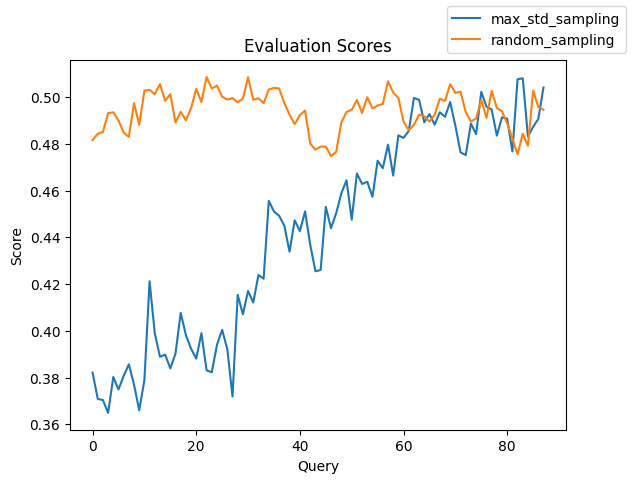

In [7]:
fig, ax = plt.subplots()

ax.plot(range(len(scores_mss)), scores_mss, label="max_std_sampling")
ax.plot(range(len(scores_rs)), scores_rs, label="random_sampling")
ax.set_title('Evaluation Scores')
ax.set(xlabel='Query', ylabel='Score')
fig.legend()

plt.show()

### Results:

uncertainty sampling: scores generally improve as more samples are queried, indicating that the active learning approach is effective in improving the model's performance.

random sampling: scores are relatively consistent throughout the queries, without significant improvement over time.

Overall, the results demonstrate the effectiveness of the committee-based active learning approach in improving the model's performance compared to random sampling.